<a href="https://colab.research.google.com/github/DavidToth23/music_instrument_classification/blob/main/third_phase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving nsynth-valid.jsonwav.tar.gz to nsynth-valid.jsonwav.tar.gz


In [4]:
import tarfile

with tarfile.open("nsynth-valid.jsonwav.tar.gz", "r:gz") as tar:
    tar.extractall("nsynth-valid")

/tmp/ipython-input-4291929459.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("nsynth-valid")


In [5]:
import os

print(os.listdir("nsynth-valid")[:10])


['nsynth-valid']


In [6]:
import json, os
from pathlib import Path
import pandas as pd

SPLIT_DIR = Path("nsynth-valid/nsynth-valid")
META_PATH = SPLIT_DIR / "examples.json"

# map porodica (family_id -> ime)
FAMILY_MAP = {
    0: "bass", 1: "brass", 2: "flute", 3: "guitar", 4: "keyboard",
    5: "mallet", 6: "organ", 7: "reed", 8: "string", 9: "synth_lead", 10: "vocal"
}

with open(META_PATH, "r") as f:
    meta = json.load(f)

rows = []
for key, m in meta.items():
    rel = m.get("audio_path")
    if not rel:
        cand = list((SPLIT_DIR / "audio").rglob(f"{key}.wav"))
        if not cand:
            continue
        rel = cand[0].relative_to(SPLIT_DIR).as_posix()

    rows.append({
        "id": key,
        "wav": str((SPLIT_DIR / rel).resolve()),
        "family_id": int(m["instrument_family"]),
        "family": FAMILY_MAP[int(m["instrument_family"])],
        "pitch": int(m["pitch"]),
        "velocity": int(m["velocity"])
    })

df = pd.DataFrame(rows)
df.head(), df["family"].value_counts().sort_index()


(                                id  \
 0    keyboard_acoustic_004-060-025   
 1       bass_synthetic_033-050-100   
 2       bass_synthetic_009-052-050   
 3  keyboard_electronic_003-064-127   
 4       bass_synthetic_034-030-050   
 
                                                  wav  family_id    family  \
 0  /content/nsynth-valid/nsynth-valid/audio/keybo...          4  keyboard   
 1  /content/nsynth-valid/nsynth-valid/audio/bass_...          0      bass   
 2  /content/nsynth-valid/nsynth-valid/audio/bass_...          0      bass   
 3  /content/nsynth-valid/nsynth-valid/audio/keybo...          4  keyboard   
 4  /content/nsynth-valid/nsynth-valid/audio/bass_...          0      bass   
 
    pitch  velocity  
 0     60        25  
 1     50       100  
 2     52        50  
 3     64       127  
 4     30        50  ,
 family
 bass        2638
 brass        886
 flute        470
 guitar      2081
 keyboard    2404
 mallet       663
 organ       1598
 reed         720
 string  

In [7]:

K = 800
mini = (df.groupby("family_id", group_keys=False)
          .apply(lambda g: g.sample(min(K, len(g)), random_state=42))
          .reset_index(drop=True))

mini["family"].value_counts().sort_index()
mini.to_csv("nsynth_mini.csv", index=False)


/tmp/ipython-input-2035236481.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(K, len(g)), random_state=42))


In [8]:
!pip -q install torch torchaudio librosa soundfile --upgrade

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import librosa

SR = 16000
N_FFT = 1024
HOP = 256
N_MELS = 64
FMIN = 20
FMAX = 8000

LABELS = sorted(mini["family"].unique())
label2idx = {l:i for i,l in enumerate(LABELS)}
idx2label = {i:l for l,i in label2idx.items()}

class NSynthMelDataset(Dataset):
    def __init__(self, table, augment=False):
        self.table = table.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.table)

    def __getitem__(self, i):
        row = self.table.iloc[i]
        wav_path = row["wav"]
        y, sr = librosa.load(wav_path, sr=SR, mono=True)
        if self.augment:
            gain = 10**(np.random.uniform(-3,3)/20)
            y = y * gain

        S = librosa.feature.melspectrogram(
            y=y, sr=SR, n_fft=N_FFT, hop_length=HOP,
            n_mels=N_MELS, fmin=FMIN, fmax=FMAX
        )
        S_db = librosa.power_to_db(S, ref=np.max).astype(np.float32)
        mu, sigma = S_db.mean(), S_db.std() + 1e-6
        S_norm = (S_db - mu) / sigma
        # PyTorch očekuje [C, H, W]
        x = torch.from_numpy(S_norm).unsqueeze(0)  # [1, n_mels, time]
        y_lbl = torch.tensor(label2idx[row["family"]], dtype=torch.long)
        return x, y_lbl


In [9]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(mini, test_size=0.2, stratify=mini["family"], random_state=42)
train_ds = NSynthMelDataset(train_df, augment=True)
val_ds   = NSynthMelDataset(val_df, augment=False)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), LABELS


(5645,
 1412,
 ['bass',
  'brass',
  'flute',
  'guitar',
  'keyboard',
  'mallet',
  'organ',
  'reed',
  'string',
  'vocal'])

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),
        )

        self.gap = nn.AdaptiveAvgPool2d((1,1))   # global average pooling
        self.fc1 = nn.Linear(256, 128)
        self.drop_fc = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCNN(n_classes=len(LABELS)).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900><function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
     Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>  
 Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py",

Ep 1: train loss 1.735 acc 0.333 | val loss 1.286 acc 0.562


  0%|          | 0/177 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900><function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
if w.is_alive(): 
             ^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>^^^
^^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/

Ep 2: train loss 1.018 acc 0.616 | val loss 0.859 acc 0.743


  0%|          | 0/177 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
        ^ ^ ^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

  0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():    
self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive():
   ^ ^ ^ ^^  ^ ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^ ^ ^ ^
    File "/usr/lib

Ep 3: train loss 0.637 acc 0.767 | val loss 0.539 acc 0.861


  0%|          | 0/177 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive():
       ^^ ^ ^ ^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^^    ^^^^
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

  0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Exception ignored in:       File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>
if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():
        ^  ^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>  File

Ep 4: train loss 0.461 acc 0.833 | val loss 0.365 acc 0.894


  0%|          | 0/177 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900><function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():
     if w.is_alive(): 
           ^^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par

  0%|          | 0/45 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900><function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive(): 
         ^ ^ ^^^^^^^^^^^^^^^^^^^^Exception ignored in: 
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^
Traceback 

Ep 5: train loss 0.315 acc 0.884 | val loss 0.270 acc 0.933


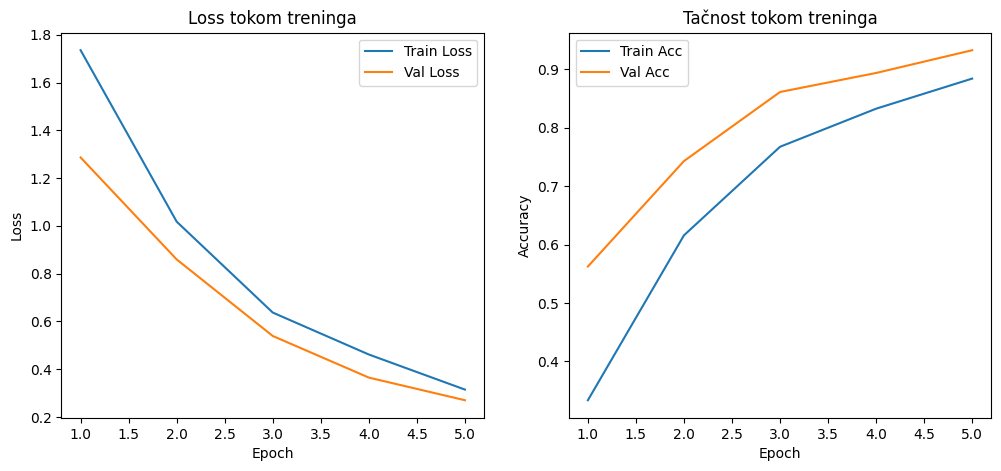

In [11]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

train_losses, val_losses = [], []
train_accs, val_accs = [], []

def run_epoch(dl, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in tqdm(dl, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        if train:
            opt.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        if train:
            loss.backward()
            opt.step()
        loss_sum += loss.item() * yb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return loss_sum/total, correct/total

EPOCHS = 5
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dl, train=True)
    va_loss, va_acc = run_epoch(val_dl, train=False)

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(f"Ep {ep}: train loss {tr_loss:.3f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.3f} acc {va_acc:.3f}")

# sačuvaj model
torch.save({"state_dict": model.state_dict(), "labels": LABELS}, "nsynth_cnn_baseline.pt")

# --- crtanje grafova ---
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss tokom treninga")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Tačnost tokom treninga")
plt.legend()

plt.show()

In [12]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# skupi sve predviđanja na validation
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(yb.numpy().tolist())

print(classification_report(y_true, y_pred, target_names=LABELS))
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABELS))))
cm


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c0d86964900> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^ ^^ ^ ^ ^  ^ ^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^  ^ ^
    File "/usr/lib

              precision    recall  f1-score   support

        bass       0.99      0.82      0.90       160
       brass       0.99      0.99      0.99       160
       flute       0.98      0.98      0.98        94
      guitar       0.73      0.97      0.84       160
    keyboard       0.92      0.76      0.84       160
      mallet       0.91      0.91      0.91       133
       organ       0.99      0.99      0.99       160
        reed       0.97      0.98      0.98       144
      string       0.95      0.98      0.97       160
       vocal       1.00      0.99      0.99        81

    accuracy                           0.93      1412
   macro avg       0.95      0.94      0.94      1412
weighted avg       0.94      0.93      0.93      1412



array([[131,   0,   0,  21,   0,   2,   0,   3,   3,   0],
       [  0, 159,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,  92,   0,   0,   0,   0,   0,   2,   0],
       [  1,   0,   0, 155,   3,   0,   1,   0,   0,   0],
       [  0,   0,   0,  26, 122,  10,   0,   0,   2,   0],
       [  0,   0,   0,   7,   5, 121,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0, 159,   0,   0,   0],
       [  0,   1,   0,   0,   1,   0,   0, 141,   1,   0],
       [  0,   0,   0,   2,   1,   0,   0,   0, 157,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0,   0,  80]])